In [1]:
# Packages
from time import time
import nltk
import numpy as np
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score
warnings.filterwarnings('ignore')

In [2]:
import multiprocessing as mp
cores = mp.cpu_count()

In [3]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

# Import dataset

In [4]:
train = pd.read_csv('train.csv', header=None)
train['Text'] = train[1]+' '+train[2]
train = train.drop(columns=[1,2])

In [5]:
train[0] = train[0].map(lambda x: x-1)
train.rename(columns={0:'Sentiment'},inplace=True)

In [6]:
test = pd.read_csv('test.csv', header=None)
test['Text'] = test[1]+' '+test[2]
test = test.drop(columns=[1,2])

In [7]:
test[0] = test[0].map(lambda x: x-1)
test.rename(columns={0:'Sentiment'},inplace=True)

In [8]:
train.tail()

,Sentiment,Text
3599995,0,Don't do it!! The high chair looks great when ...
3599996,0,"Looks nice, low functionality I have used this..."
3599997,0,"compact, but hard to clean We have a small hou..."
3599998,0,what is it saying? not sure what this book is ...
3599999,1,Makes My Blood Run Red-White-And-Blue I agree ...


In [9]:
test.tail()

,Sentiment,Text
399995,0,Unbelievable- In a Bad Way We bought this Thom...
399996,0,"Almost Great, Until it Broke... My son recieve..."
399997,0,Disappointed !!! I bought this toy for my son ...
399998,1,Classic Jessica Mitford This is a compilation ...
399999,0,"Comedy Scene, and Not Heard This DVD will be a..."


In [10]:
train['Sentiment'].value_counts()

1    1800000
0    1800000
Name: Sentiment, dtype: int64

In [11]:
test['Sentiment'].value_counts()

1    200000
0    200000
Name: Sentiment, dtype: int64

# Text Processing

In [12]:
# 1. Tokenisation (casual module)
from nltk.tokenize import TweetTokenizer
Tokenizer = TweetTokenizer()
# 2. Remove punctuation
import string
# 3. Remove stopwords
from nltk.corpus import stopwords
# 4. Stemming
from nltk.stem.porter import PorterStemmer

In [ ]:
def process_text(text):
    text = str(text)
    tokenized = Tokenizer.tokenize(text)
    tokenized_no_punctuation = [word.lower() for word in tokenized if word not in string.punctuation]
    tokenized_no_stopwords = [word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
    token = [PorterStemmer().stem(word) for word in tokenized_no_stopwords if word != '️']
    token = ' '.join(token)
    return token

In [ ]:
def process_text_ez(text):
    text = str(text)
    tokenized = Tokenizer.tokenize(text)
    tokenized_lower = [word.lower() for word in tokenized]
    tokenized_stem = [PorterStemmer().stem(word) for word in tokenized_lower if word != '']
    token = ' '.join(tokenized_stem)
    return token

In [ ]:
tqdm.pandas(desc="Progress bar")

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lis18gl.SHEFUNIAD\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
fullset = pd.concat([train,test],axis=0,ignore_index=True)

In [19]:
fullset.tail()

,Sentiment,Text
3999995,0,Unbelievable- In a Bad Way We bought this Thom...
3999996,0,"Almost Great, Until it Broke... My son recieve..."
3999997,0,Disappointed !!! I bought this toy for my son ...
3999998,1,Classic Jessica Mitford This is a compilation ...
3999999,0,"Comedy Scene, and Not Heard This DVD will be a..."


In [ ]:
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))

In [ ]:
fullset['Token'] = apply_by_multiprocessing(fullset['Text'], process_text, workers=cores)

In [ ]:
fullset.head()

,Sentiment,Text,Token
0,1,Stuning even for the non-gamer This sound trac...,stune even non-gam sound track beauti paint se...
1,1,The best soundtrack ever to anything. I'm read...,best soundtrack ever anyth i'm read lot review...
2,1,Amazing! This soundtrack is my favorite music ...,amaz soundtrack favorit music time hand intens...
3,1,Excellent Soundtrack I truly like this soundtr...,excel soundtrack truli like soundtrack enjoy v...
4,1,"Remember, Pull Your Jaw Off The Floor After He...",rememb pull jaw floor hear play game know divi...


In [ ]:
%%time
(fullset.Token.apply(len)).max()

CPU times: user 1.59 s, sys: 67.2 ms, total: 1.66 s
Wall time: 1.65 s


953

In [ ]:
fullset.tail()

,Sentiment,Text,Token
3999995,0,Unbelievable- In a Bad Way We bought this Thom...,unbeliev bad way bought thoma son huge thoma f...
3999996,0,"Almost Great, Until it Broke... My son recieve...",almost great broke ... son reciev birthday gif...
3999997,0,Disappointed !!! I bought this toy for my son ...,disappoint bought toy son love thoma toy need ...
3999998,1,Classic Jessica Mitford This is a compilation ...,classic jessica mitford compil wide rang mitfo...
3999999,0,"Comedy Scene, and Not Heard This DVD will be a...",comedi scene heard dvd disappoint get hope see...


In [ ]:
fullset[['Sentiment','Token']].to_csv('fullset_processed.csv',index=0)

# Import Processed csv

In [5]:
!wget 'http://uk.boblee.cn/v/fullset_ez_processed.csv'

--2019-07-22 16:52:19--  http://uk.boblee.cn/v/fullset_ez_processed.csv
Resolving uk.boblee.cn (uk.boblee.cn)... 35.246.85.216
Connecting to uk.boblee.cn (uk.boblee.cn)|35.246.85.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1562862430 (1.5G) [application/octet-stream]
Saving to: ‘fullset_ez_processed.csv’

fullset_ez_processe 100%[===================>]   1.46G  30.3MB/s    in 51s     

2019-07-22 16:53:11 (29.3 MB/s) - ‘fullset_ez_processed.csv’ saved [1562862430/1562862430]



In [ ]:
fullset = pd.read_csv('fullset_ez_processed.csv')

In [7]:
fullset.tail()

,Sentiment,Token
3999995,0,unbeliev in a bad way we bought thi thoma for ...
3999996,0,almost great until it broke ... my son reciev ...
3999997,0,disappoint i bought thi toy for my son who lov...
3999998,1,classic jessica mitford thi is a compil of a w...
3999999,0,comedi scene and not heard thi dvd will be a d...


In [ ]:
fullset['Token'] = fullset['Token'].apply(str)

In [9]:
(fullset.Token.apply(len)).describe(percentiles=[.95, .99]).round(0)

count    4000000.0
mean         388.0
std          213.0
min            3.0
50%          344.0
95%          803.0
99%          888.0
max         1003.0
Name: Token, dtype: float64

In [ ]:
# Randomly split indexes 90/10
train_x, valid_x, train_y, valid_y = train_test_split(fullset['Token'], fullset['Sentiment'], train_size=0.9, random_state=1, stratify=fullset.Sentiment)

## Count Vectors as features

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

print('# CV + 1-gram')
count_vect_1n = CountVectorizer(analyzer='word', ngram_range=(1,1), token_pattern=r'\w{1,}', max_features=10000)
count_vect_1n.fit(fullset['Token'])

print('# CV + 2-gram')
count_vect_2n = CountVectorizer(analyzer='word', ngram_range=(1,2), token_pattern=r'\w{1,}', max_features=10000)
count_vect_2n.fit(fullset['Token'])

print("# CV + 3-gram")
count_vect_3n = CountVectorizer(analyzer='word', ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=10000)
count_vect_3n.fit(fullset['Token'])

# CV + 1-gram


KeyboardInterrupt: ignored

In [ ]:
# Transform the training and validation data using count vectorizer object
xtrain_count_1n =  count_vect_1n.transform(train_x)
xvalid_count_1n =  count_vect_1n.transform(valid_x)
print('# Finish 1n')

xtrain_count_2n =  count_vect_2n.transform(train_x)
xvalid_count_2n =  count_vect_2n.transform(valid_x)
print('# Finish 2n')

xtrain_count_3n =  count_vect_3n.transform(train_x)
xvalid_count_3n =  count_vect_3n.transform(valid_x)
print('# Finish 3n')

# Finish 1n
# Finish 2n
# Finish 3n


## TF-IDF Vectors + N-gram as features

In [ ]:
# TF-IDF + 1-gram
tfidf_vect_1n = TfidfVectorizer(analyzer='word', ngram_range=(1,1), token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect_1n.fit(fullset['Token'])

# TF-IDF + 2-gram
tfidf_vect_2n = TfidfVectorizer(analyzer='word', ngram_range=(1,2), token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect_2n.fit(fullset['Token'])

# TF-IDF + 3-gram
tfidf_vect_3n = TfidfVectorizer(analyzer='word', ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect_3n.fit(fullset['Token'])

In [ ]:
xtrain_tfidf_1n =  tfidf_vect_1n.transform(train_x)
xvalid_tfidf_1n =  tfidf_vect_1n.transform(valid_x)

xtrain_tfidf_2n =  tfidf_vect_2n.transform(train_x)
xvalid_tfidf_2n =  tfidf_vect_2n.transform(valid_x)

xtrain_tfidf_3n =  tfidf_vect_3n.transform(train_x)
xvalid_tfidf_3n =  tfidf_vect_3n.transform(valid_x)

## Word2vec as features

In [11]:
!wget 'http://uk.boblee.cn/v/GoogleNews-vectors-negative300.bin'

--2019-07-22 16:55:36--  http://uk.boblee.cn/v/GoogleNews-vectors-negative300.bin
Resolving uk.boblee.cn (uk.boblee.cn)... 35.246.85.216
Connecting to uk.boblee.cn (uk.boblee.cn)|35.246.85.216|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3644258522 (3.4G) [application/octet-stream]
Saving to: ‘GoogleNews-vectors-negative300.bin’

GoogleNews-vectors- 100%[===================>]   3.39G  28.1MB/s    in 2m 2s   

2019-07-22 16:57:38 (28.5 MB/s) - ‘GoogleNews-vectors-negative300.bin’ saved [3644258522/3644258522]



In [ ]:
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

In [ ]:
#sentence = [(i.split()) for i in fullset.Token]
#w2vmodel = word2vec.Word2Vec(sentence, min_count=1, size=300, workers=cores)
w2vmodel = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
w2vmodel.most_similar(['book'])

[('tome', 0.7485830783843994),
 ('books', 0.7379178404808044),
 ('memoir', 0.7302927374839783),
 ('paperback_edition', 0.6868364810943604),
 ('autobiography', 0.6741527915000916),
 ('memoirs', 0.6505153179168701),
 ('Book', 0.6479282379150391),
 ('paperback', 0.6471226811408997),
 ('novels', 0.6341458559036255),
 ('hardback', 0.6283079385757446)]

In [ ]:
#train_w2v_x, valid_w2v_x, train_w2v_y, valid_w2v_y = train_test_split(fullset['Text'], train_sp['Sentiment'], train_size=0.8, random_state=1, stratify=train_sp.Sentiment)

In [ ]:
def get_sent_vec(size, sent, model):
    vec = np.zeros(size).reshape(1,size)
    count = 0
    for word in str(sent).split():
        try:
            vec += model[word].reshape(1,size)
            count += 1
        except:
            continue
    if count != 0:
        vec /= count
    return vec

def get_train_vec(train_x, valid_x, model):
    train_vec = np.concatenate([get_sent_vec(300, sent, model) for sent in train_x])
    test_vec = np.concatenate([get_sent_vec(300, sent, model) for sent in valid_x])
    return train_vec, test_vec

In [ ]:
# Lower + No punctuation + No stopwords+ Stemming
train_vec, valid_vec = get_train_vec(train_x, valid_x, w2vmodel)
# Lower words + Stemming
#train_w2v_vec, valid_w2v_vec = get_train_vec(train_w2v_x, valid_w2v_x, w2vmodel)

# Model Training (Traditional ML)

In [12]:
!wget 'https://raw.githubusercontent.com/bobleer/AmazonViews/master/amazon_review_polarity_csv/statlearning.py'

--2019-07-22 16:57:39--  https://raw.githubusercontent.com/bobleer/AmazonViews/master/amazon_review_polarity_csv/statlearning.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24746 (24K) [text/plain]
Saving to: ‘statlearning.py’

statlearning.py     100%[===================>]  24.17K  --.-KB/s    in 0.01s   

2019-07-22 16:57:39 (2.40 MB/s) - ‘statlearning.py’ saved [24746/24746]



In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix, roc_curve
from statlearning import plot_confusion_matrix

In [ ]:
from sklearn import naive_bayes, svm, linear_model

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    trm = classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = trm.predict(feature_vector_valid)
    prob = trm.predict_proba(feature_vector_valid)
    
    '''
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    '''
    print('Accuracy:', accuracy_score(predictions, valid_y).round(4))
    print('Precision:', precision_score(predictions, valid_y).round(4))
    print('Recall:', recall_score(predictions, valid_y).round(4))
    print('F1 Score:', f1_score(predictions, valid_y).round(4))
    '''
    confusion = confusion_matrix(predictions, valid_y)
    fig, ax = plt.subplots(figsize=(8,6))
    plot_confusion_matrix(confusion, classes=['negative','positive'], normalize=True)
    plt.show()
    '''
    #print('AUC:', roc_auc_score(valid_y, prob[:,1]).round(4),'\n')
    
    fpr, tpr, _ = roc_curve(valid_y, prob[:,1])
    auc = roc_auc_score(valid_y, prob[:,1])

    fig, ax= plt.subplots(figsize=(14,9))
    ax.plot(fpr, tpr, label='ROC curve (AUC = {:.3f})'.format(auc))
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve for the Naive Bayes Classifier', fontsize=16)
    sns.despine()
    plt.legend()
    plt.show()

##  Naive Bayes

In [ ]:
print("# Naive Bayes + Count Vectors + 1-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_count_1n, train_y, xvalid_count_1n)

print("\n# Naive Bayes + Count Vectors + 2-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_count_2n, train_y, xvalid_count_2n)

print("\n# Naive Bayes + Count Vectors + 3-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_count_3n, train_y, xvalid_count_3n)

In [ ]:
print("# Naive Bayes + TF-IDF + 1-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n)

print("\n# Naive Bayes + TF-IDF + 2-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_2n, train_y, xvalid_tfidf_2n)

print("\n# Naive Bayes + TF-IDF + 3-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)

# Naive Bayes + 1234 + Word2vec
Accuracy: 0.577
Precision: 0.6173
Recall: 0.5713
F1 Score: 0.5934


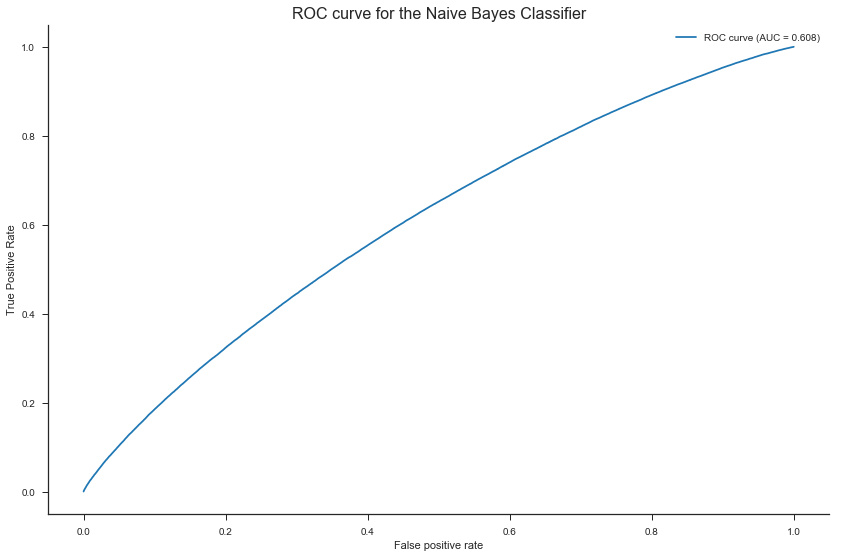

In [ ]:
print("# Naive Bayes + 1234 + Word2vec")
train_model(naive_bayes.BernoulliNB(), train_vec, train_y, valid_vec)

#print("\n# Naive Bayes + 14 + Word2vec")
#train_model(naive_bayes.BernoulliNB(), train_w2v_vec, train_y, valid_w2v_vec)

## SVM 

In [ ]:
print("SVM + Count Vectors + 1-gram")
train_model(svm.SVC(verbose=True), xtrain_count_1n, train_y, xvalid_count_1n)

print("\nSVM + Count Vectors + 2-gram")
train_model(svm.SVC(verbose=True), xtrain_count_2n, train_y, xvalid_count_2n)

print("\nSVM + Count Vectors + 3-gram")
train_model(svm.SVC(verbose=True), xtrain_count_3n, train_y, xvalid_count_3n)

In [ ]:
print("SVM + TF-IDF + 1-gram")
train_model(svm.SVC(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n)

print("\nSVM + TF-IDF + 2-gram")
train_model(svm.SVC(), xtrain_tfidf_2n, train_y, xvalid_tfidf_2n)

print("\nSVM + TF-IDF + 3-gram")
train_model(svm.SVC(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)

In [ ]:
print("SVM + 1234 + Word2vec")
train_model(svm.SVC(), train_vec, train_y, valid_vec)

#print("\nSVM + 14 + Word2vec")
#train_model(svm.SVC(), train_w2v_vec, train_y, valid_w2v_vec)

SVM + 1234 + Word2vec


## Logistic Regression 

In [ ]:
print("Logistic Regression + Count Vectors + 1-gram")
train_model(linear_model.LogisticRegression(), xtrain_count_1n, train_y, xvalid_count_1n)

print("\nLogistic Regression + Count Vectors + 2-gram")
train_model(linear_model.LogisticRegression(), xtrain_count_2n, train_y, xvalid_count_2n)

print("\nLogistic Regression + Count Vectors + 3-gram")
train_model(linear_model.LogisticRegression(), xtrain_count_3n, train_y, xvalid_count_3n)

In [ ]:
print("Logistic Regression + TF-IDF + 1-gram")
train_model(linear_model.LogisticRegression(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n)

print("\nLogistic Regression + TF-IDF + 2-gram")
train_model(linear_model.LogisticRegression(), xtrain_tfidf_2n, train_y, xvalid_tfidf_3n)

print("\nLogistic Regression + TF-IDF + 3-gram")
train_model(linear_model.LogisticRegression(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)

In [ ]:
print("Logistic Regression + 1234 + Word2vec")
train_model(linear_model.LogisticRegression(), train_vec, train_y, valid_vec)

#print("\nLogistic Regression + 14 + Word2vec")
#train_model(linear_model.LogisticRegression(), train_w2v_vec, train_y, valid_w2v_vec)

# Model Training (DNN)

In [15]:
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

Using TensorFlow backend.


In [ ]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [20]:
fullset['Text'] = fullset['Text'].apply(str)

In [21]:
(fullset['Text'].apply(len)).describe(percentiles=[.95, .99]).round(0)

count    4000000.0
mean         431.0
std          238.0
min            3.0
50%          382.0
95%          894.0
99%          988.0
max         1014.0
Name: Text, dtype: float64

In [24]:
fullset.rename(columns={'Text':'Token'},inplace=True)

In [25]:
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.16
TEST_SPLIT = 0.2

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

t0 = time()
# One-hot

tokenizer = Tokenizer()
tokenizer.fit_on_texts(fullset['Token'])
sequences = tokenizer.texts_to_sequences(fullset['Token'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(fullset['Sentiment']))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

print('Time Spent:', time()-t0, 's')

In [ ]:
t0 = time()

p1 = int(len(data)*(1-VALIDATION_SPLIT-TEST_SPLIT))
p2 = int(len(data)*(1-TEST_SPLIT))
x_train = data[:p1]
y_train = labels[:p1]
x_val = data[p1:p2]
y_val = labels[p1:p2]
x_test = data[p2:]
y_test = labels[p2:]
print('train rows:', len(x_train))
print('valid rows:', len(x_val))
print('test rows:', len(x_test))

print('Time Spent:', time()-t0, 's')

In [21]:
# Word2vec
VECTOR_DIR = 'GoogleNews-vectors-negative300.bin' # 词向量模型文件

from keras.utils import plot_model
from keras.layers import Embedding
import gensim

w2v_model = gensim.models.KeyedVectors.load_word2vec_format(VECTOR_DIR, binary=True)
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

NameError: ignored

In [23]:
for word, i in tqdm(word_index.items()): 
    if str(word) in w2v_model:
        embedding_matrix[i] = np.asarray(w2v_model[str(word)],
                                         dtype='float32')
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

  0%|          | 0/926452 [00:00<?, ?it/s]


ValueError: ignored

## CNN

In [ ]:
# CNN + One-hot
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

cnn = Sequential()
cnn.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
cnn.add(MaxPooling1D(3))
cnn.add(Flatten())
cnn.add(Dense(EMBEDDING_DIM, activation='relu'))
cnn.add(Dense(labels.shape[1], activation='softmax'))
cnn.summary()

cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
history = cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=128)


result = cnn.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

In [ ]:
# CNN + Word2vec
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

cnn_w2v = Sequential()
cnn_w2v.add(embedding_layer)
cnn_w2v.add(Dropout(0.2))
cnn_w2v.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
cnn_w2v.add(MaxPooling1D(3))
cnn_w2v.add(Flatten())
cnn_w2v.add(Dense(EMBEDDING_DIM, activation='relu'))
cnn_w2v.add(Dense(labels.shape[1], activation='softmax'))
cnn_w2v.summary()

cnn_w2v.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
history = cnn_w2v.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=128)

result = cnn_w2v.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

## LSTM 

In [ ]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, MaxPooling1D, Embedding
from keras.models import Sequential

lstm = Sequential()
lstm.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
lstm.add(Dropout(0.2))
lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(1, activation='sigmoid'))
lstm.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm.add(Dense(labels.shape[1], activation='softmax'))
lstm.summary()

lstm.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
history = lstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=128)

result = lstm.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

In [ ]:
# Word2vec
from keras.utils import plot_model
from keras.layers import Embedding

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items(): 
    if str(word) in w2vmodel:
        embedding_matrix[i] = np.asarray(w2vmodel[str(word)],dtype='float32')
        
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)


In [ ]:
# LSTM + Word2vec
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, MaxPooling1D, Embedding
from keras.models import Sequential

lstm_w2v = Sequential()
lstm_w2v.add(embedding_layer)
lstm_w2v.add(Dropout(0.2))
lstm_w2v.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_w2v.add(Dense(1, activation='sigmoid'))
lstm_w2v.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm_w2v.add(Dense(labels.shape[1], activation='softmax'))
lstm_w2v.summary()

lstm_w2v.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
history = lstm_w2v.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM + Word2vec: Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

result = lstm_w2v.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

## Hybrid Model

In [ ]:
# CNN + LSTM
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Conv1D, MaxPooling1D, Embedding, TimeDistributed
from keras.models import Sequential

hybrid = Sequential()
hybrid.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
hybrid.add(Dropout(0.2))
hybrid.add(Conv1D(250, 3, activation='relu'))
hybrid.add(MaxPooling1D(pool_size=3))
hybrid.add(LSTM(128))
hybrid.add(Dense(2, activation='sigmoid'))
hybrid.add(Dense(EMBEDDING_DIM, activation='relu'))
hybrid.add(Dense(labels.shape[1], activation='softmax'))
hybrid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hybrid.summary()

hybrid.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
history = hybrid.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=128)

result = hybrid.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

In [ ]:
# CNN + LSTM + Word2vec
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Conv1D, MaxPooling1D, Embedding, TimeDistributed
from keras.models import Sequential

hybrid_w2v = Sequential()
hybrid_w2v.add(embedding_layer)
hybrid_w2v.add(Dropout(0.2))
hybrid_w2v.add(Conv1D(250, 3, activation='relu'))
hybrid_w2v.add(MaxPooling1D(pool_size=3))
hybrid_w2v.add(LSTM(128))
hybrid_w2v.add(Dense(2, activation='sigmoid'))
hybrid_w2v.add(Dense(EMBEDDING_DIM, activation='relu'))
hybrid_w2v.add(Dense(labels.shape[1], activation='softmax'))
hybrid_w2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hybrid_w2v.summary()

hybrid_w2v.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
history = hybrid_w2v.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN + LSTM + Word2vec: Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

result = hybrid_w2v.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

# Optimisation (CV: Parameters & Features Selection)

# Reflection